In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from math import *
import numpy as np
import h5py

from OpticalBeam import *

# Single-Frequency content of the radiation field
# recorded on a screen in a TEUFEL run

### Get the file name:
Instead of using a fixed path string one can use a Tk dialog
to browse for the file to be read.

In [2]:
radfile = "/home/lehnertu/Programming/teufel/elbe-u300_screen_5m.h5"

In [6]:
from tkinter import Tk
from tkinter import filedialog

Tk().withdraw()
radfile = filedialog.askopenfilenames()[0]
print(radfile)

/home/lehnertu/Programming/teufel/elbe-u300_screen_10m.h5


### Read the file and report the geometry:

In [3]:
hdf = h5py.File(radfile, "r")
# Get the groups
pos = hdf['ObservationPosition']
Nx = pos.attrs.get('Nx')
Ny = pos.attrs.get('Ny')
print("Nx=%d Ny=%d" % (Nx,Ny))
print(pos)
field = hdf['ElMagField']
print(field)
t0 = field.attrs.get('t0')
dt = field.attrs.get('dt')
nots = field.attrs.get('NOTS')
print("t0=%g dt=%g NOTS=%d" % (t0, dt, nots))
pos = np.array(pos)
a = np.array(field)
hdf.close()

Nx=64 Ny=64
<HDF5 dataset "ObservationPosition": shape (64, 64, 3), type "<f8">
<HDF5 dataset "ElMagField": shape (64, 64, 1000, 6), type "<f8">
t0=2.33495e-08 dt=1e-13 NOTS=1000


In [4]:
center = (pos[0,0]+pos[Nx-1,0]+pos[0,Ny-1]+pos[Nx-1,Ny-1]) / 4.0
print("center = ", center, " m")
# delta_x and delta_y are vectors
delta_x = (pos[Nx-1,Ny//2] - pos[0,Ny//2]) / (Nx-1)
delta_y = (pos[Nx//2,Ny-1] - pos[Nx//2,0]) / (Ny-1)
# the pixel spacing
dx = sqrt(np.sum(np.square(delta_x)))
dy = sqrt(np.sum(np.square(delta_y)))
print("pixel spacing = (%.2f, %.2f) mm" % (1e3*dx,1e3*dy))
# unit vectors
e_x = delta_x / dx
e_y = delta_y / dy
if np.abs(np.dot(e_x,e_y)) > 1e-4:
    print("WARNING : e_x and e_y are not orthogonal")
    print(e_x)
    print(e_y)
# screen normal vector
normal = np.cross(delta_x,delta_y)
normal = normal / sqrt(np.sum(np.square(normal)))
print("normal = ", normal)

center =  [-5.e-03 -5.e-03  7.e+00]  m
pixel spacing = (10.00, 10.00) mm
normal =  [0. 0. 1.]


## Create a plot of amplitude and phase at a given frequency

The frequency is coaxed to the nearest frequency in the FFT raster of the given data.<br>
The two polarization directions are taken as the alignment vectors of the screen.<br>
Longitudinal fields are neglected.<br>
Only the amplitude of the E field is considered because the
B fields should be linked to E by Maxwells equations.<br>
The plots show amplitude and phase of both polarization directions. The amplitudes are linked to the same scale.

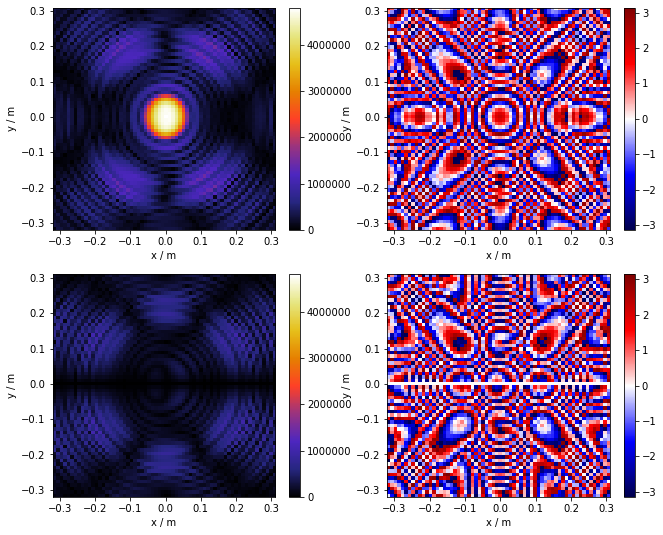

In [5]:
# the frequency for which to create the optical beam
frequency = 1.0e12
# index in the fourier spectrum
f_index = int(round(frequency*dt*nots))
beam = SingleFrequencyBeam(frequency, Nx, Ny, dx, dy)

M = np.zeros((Nx,Ny),dtype=np.cdouble)
for ix in range(Nx):
    for iy in range(Ny):
        trace = a[ix][iy]
        data = trace.transpose()
        Ex = data[0]
        Ey = data[1]
        Ez = data[2]
        EVec = np.array([Ex, Ey, Ez]).transpose()
        E_xi = np.dot(EVec,e_x)
        spect = np.fft.fft(E_xi)
        M[ix,iy] = spect[f_index]
beam.A_xi = ReorderBeamMatrix(M)

M = np.zeros((Nx,Ny),dtype=np.cdouble)
for ix in range(Nx):
    for iy in range(Ny):
        trace = a[ix][iy]
        data = trace.transpose()
        Ex = data[0]
        Ey = data[1]
        Ez = data[2]
        EVec = np.array([Ex, Ey, Ez]).transpose()
        E_eta = np.dot(EVec,e_y)
        spect = np.fft.fft(E_eta)
        M[ix,iy] = spect[f_index]
beam.A_eta = ReorderBeamMatrix(M)

beam.plot()
plt.show()